# **QML Exercise**: Classification with Quantum & Classical Models
In this exercise, we will explore how Quantum Machine Learning (QML) can be used to solve a complex, two-dimensional classification problem. We will build two types of quantum classifiers and compare their performance against a standard classical model.

\

A major bottleneck in QML can be the time it takes to simulate quantum circuits. To address this, we will leverage **lightning.qubit**, a high-performance CPU simulator provided by PennyLane, to dramatically speed up the computation.

\

**Getting Started**: Installing Libraries
First, we need to install the necessary Python libraries. This code block will install PennyLane for quantum programming, Scikit-learn for classical machine learning tools, Matplotlib for plotting, and tqdm for progress bars.

In [ ]:
!pip install pennylane --quiet
!pip install scikit-learn --quiet
!pip install matplotlib --quiet
!pip install tqdm --quiet
!pip install ipywidgets --quiet

# **A Quick Primer on Quantum Circuits**
Before we apply quantum computing to machine learning, let's understand the basics of building a quantum circuit.

A **quantum circuit** is a sequence of operations, called **quantum gates**, applied to qubits.

* **Qubits**: These are the basic units of quantum information. Unlike classical bits that are either 0 or 1, a qubit can exist in a **superposition** of both states simultaneously.

* **Quantum Gates**: These are operations that manipulate the state of the qubits. For example, a Hadamard gate puts a qubit into a superposition, and a CNOT gate entangles two qubits.

* **Measurement**: At the end of a circuit, we measure the qubits, which collapses their superposition into a classical state (either 0 or 1).

\

**Building a Simple Circuit in PennyLane**

Let's build a simple two-qubit circuit that creates an entangled state known as a Bell state.

* **Define a Device**: A device is the "backend" that will run our circuit. It can be a quantum simulator (like default.qubit) or a real quantum computer.

* **Create a QNode**: A QNode is a quantum circuit bound to a specific device. We define it in Python using the @qml.qnode decorator.

* **Define the Circuit**: Inside our QNode function, we define the sequence of gates.

* **Return a Measurement**: The function must return a classical measurement result.

In [ ]:
import pennylane as qml
import matplotlib.pyplot as plt

# 1. Define a device (a 2-qubit simulator)
dev_simple = qml.device("default.qubit", wires=2)

# 2. Create a QNode bound to the device
@qml.qnode(dev_simple)
def simple_bell_state_circuit():
    """
    This quantum circuit creates a Bell state by applying a
    Hadamard gate and a CNOT gate.
    """
    # 3. Apply gates
    qml.Hadamard(wires=0)  # Puts the first qubit in a superposition
    qml.CNOT(wires=[0, 1])   # Entangles the two qubits

    # 4. Return a measurement (in this case, the state probabilities)
    return qml.probs(wires=[0, 1])

# Run the circuit
result = simple_bell_state_circuit()
print(f"Output probabilities: {result}")
print("This indicates a 50% chance of measuring |00> and a 50% chance of measuring |11>.")


Output probabilities: [0.5 0.  0.  0.5]
This indicates a 50% chance of measuring |00> and a 50% chance of measuring |11>.


**Visualizing the Circuit**

PennyLane makes it easy to visualize what we've just built. We can get both a graphical representation and a text-based one.

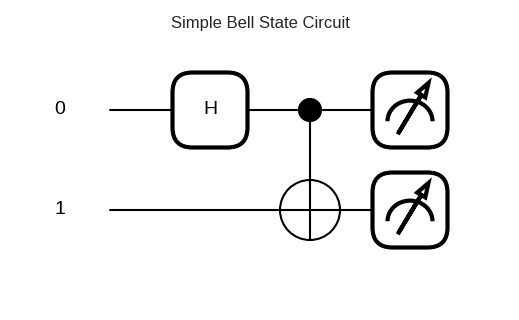


Circuit Diagram (Text):
0: ──H─╭●─┤ ╭Probs
1: ────╰X─┤ ╰Probs


In [ ]:
# Draw the circuit graphically
fig, ax = qml.draw_mpl(simple_bell_state_circuit)()
fig.suptitle("Simple Bell State Circuit")
plt.show()

# You can also get a text-based drawing
print("\nCircuit Diagram (Text):")
print(qml.draw(simple_bell_state_circuit)())


This simple example shows the fundamental workflow of creating and running a quantum circuit. The machine learning models we build next will use these same principles but with more complex circuits.

# **Conceptual Overview for Beginners**
Before we get into the code, let's break down some of the key concepts for those new to machine learning or quantum computing.

\

**What is a Support Vector Machine (SVM)?**

A **Support Vector Machine (SVM)** is a powerful and popular supervised machine learning algorithm used for classification tasks. Imagine you have a dataset with two categories of points on a graph. The goal of an SVM is to find the best possible line (or hyperplane in higher dimensions) that separates these two categories. This line is called the "decision boundary". The "best" line is the one that is as far away as possible from the closest points in each category. These closest points are called "support vectors," which give the SVM its name.

\

**What is a Kernel?**

Sometimes, data isn't easily separable by a straight line. This is where kernels come in. A kernel is a mathematical function that takes the original, non-separable data and transforms it into a higher-dimensional space where it becomes linearly separable. This is often called the "kernel trick." Think of it as adding a new dimension to your data to make it easier to draw a dividing line. The function that performs this transformation is the kernel.

\

**What is a Quantum Support Vector Machine (QSVM)?**

A **Quantum Support Vector Machine (QSVM)** gives the concept of a kernel a quantum twist. Instead of using a classical mathematical function as a kernel, a QSVM uses a quantum circuit to transform the data. This quantum circuit, also known as a "feature map," encodes the classical data into a quantum state. By doing this, we can explore a much larger and more complex feature space than what is available to classical computers. The hope is that this quantum-enhanced feature space will allow us to find better decision boundaries for our classification problems.

# **Part 1: Generating the 2D "Two Moons" Data**

We will start by generating a "two moons" dataset using Scikit-learn. This dataset is a classic example of a problem where the two classes are not linearly separable, meaning you can't draw a single straight line to separate them perfectly. This makes it an interesting challenge for our models.


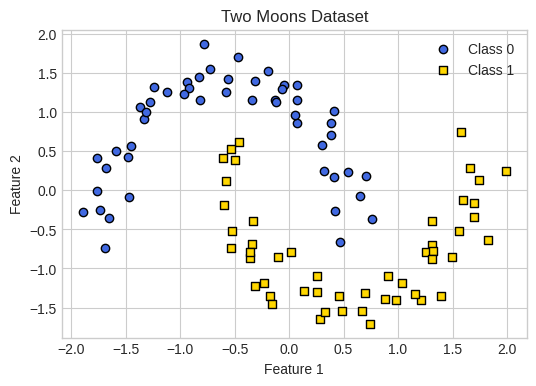

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm # Import tqdm for progress bars

# Generate the two moons dataset
X, Y = make_moons(n_samples=100, noise=0.1, random_state=42)

# It's good practice to scale the data for kernel methods
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Plot the data to see the challenge
plt.figure(figsize=(6, 4))
plt.scatter(X_scaled[Y==0, 0], X_scaled[Y==0, 1], c="royalblue", marker="o", edgecolors="k", label="Class 0")
plt.scatter(X_scaled[Y==1, 0], X_scaled[Y==1, 1], c="gold", marker="s", edgecolors="k", label="Class 1")
plt.title("Two Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


# **Part 2: Building and Training the QSVM**

This is where we define our quantum kernel. We specify **lightning.qubit** as our device, which uses a highly optimized C++ backend to run simulations much faster than the default Python-based simulator.

\

**Defining the Quantum Kernel**

The kernel is created by a quantum circuit that encodes the data points. The similarity between two data points **x1** and **x2** is calculated by running the feature map for **x1**, followed by the inverse of the feature map for **x2**, and then measuring the probability of the qubits returning to the all-zero state.

In [ ]:
# --- 2. Define an Improved Quantum Kernel ---
num_qubits = 2
dev = qml.device("lightning.qubit", wires=num_qubits)

def feature_map(x):
    """
    A more expressive feature map (the ansatz).
    This circuit encodes the data and adds entanglement.
    """
    qml.AngleEmbedding(x, wires=range(num_qubits))
    qml.CNOT(wires=[0, 1])
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)

# Define the quantum circuit that will be our feature map
@qml.qnode(dev)
def kernel_circuit(x1, x2):
    """The quantum circuit that uses the improved feature map."""
    # Apply the feature map for the first data point
    feature_map(x1)
    # Apply the inverse of the feature map for the second data point
    qml.adjoint(feature_map)(x2)
    # Return the probability of being in the all-zero state
    return qml.probs(wires=range(num_qubits))

def quantum_kernel(X1, X2):
    """The quantum kernel function that uses the circuit."""
    # The kernel is the probability of measuring the all-zero state
    # We add a tqdm progress bar to the outer loop
    return np.array([[kernel_circuit(x1, x2)[0] for x2 in X2] for x1 in tqdm(X1, desc="Kernel Rows")])

**Visualizing the QSVM Kernel Circuit**

Let's draw the circuit to see what it looks like. We'll pass in some dummy data to render the circuit diagram.

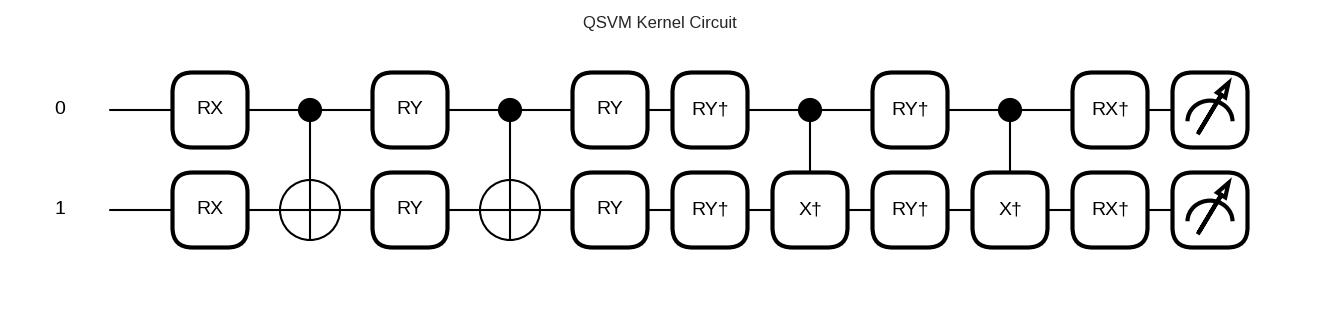

QSVM Kernel Circuit (Text):
0: ──RX(0.50)─╭●──RY(0.50)─╭●──RY(0.50)──RY(-0.20)†─╭X†──RY(-0.20)†─╭X†──RX(-0.20)†─┤ ╭Probs
1: ──RX(0.30)─╰X──RY(0.30)─╰X──RY(0.30)──RY(0.70)†──╰X†──RY(0.70)†──╰X†──RX(0.70)†──┤ ╰Probs


In [ ]:
# Create some dummy data points to draw the circuit
dummy_x1 = np.array([0.5, 0.3])
dummy_x2 = np.array([-0.2, 0.7])

# Draw the kernel circuit
fig, ax = qml.draw_mpl(kernel_circuit)(dummy_x1, dummy_x2)
fig.suptitle("QSVM Kernel Circuit")
plt.show()

# You can also get a text-based drawing
print("QSVM Kernel Circuit (Text):")
print(qml.draw(kernel_circuit)(dummy_x1, dummy_x2))

**Training the QSVM and Classical SVM**

Now we train both the QSVM and a classical SVM with a standard Radial Basis Function (RBF) kernel. This will allow us to directly compare the performance of the quantum kernel against a powerful classical alternative.

In [ ]:
# --- Train the QSVM Classifier ---
print("Calculating the improved quantum kernel matrix...")
# The 'precomputed' kernel tells the SVM to use our custom quantum kernel
qsvm_classifier = SVC(kernel=quantum_kernel)
qsvm_classifier.fit(X_scaled, Y)
print("QSVM training complete.")

# --- 3. Train the Classical SVM Classifier ---
print("\nTraining the classical SVM classifier...")
svm_classifier = SVC(kernel="rbf", gamma=0.5, C=1.0)
svm_classifier.fit(X_scaled, Y)
print("SVM training complete.")

Calculating the improved quantum kernel matrix...


Kernel Rows:   0%|          | 0/100 [00:00<?, ?it/s]

QSVM training complete.

Training the classical SVM classifier...
SVM training complete.


# **Part 3: Building a Variational Quantum Classifier (VQC)**
Now we'll build a different kind of quantum model.

**What is a Variational Quantum Classifier (VQC)?**

A **Variational Quantum Classifier (VQC)** is another type of quantum machine learning model. Instead of using a quantum circuit as a kernel for a classical SVM, a VQC uses a "parameterized" quantum circuit as the core of the classifier itself.

Here's a simple breakdown of how it works:

* **Data Encoding**: We first encode our classical data into a quantum state.

* **Variational Circuit**: This is the heart of the VQC. It's a quantum circuit with adjustable parameters (or "weights"). We can think of these as knobs we can turn to change the behavior of the circuit.

* **Measurement**: After the data is processed by the variational circuit, we measure one of the qubits. The outcome of this measurement is used to make a prediction (e.g., class "0" or "1").

* **Training**: We use a classical optimizer to "tune" the parameters of our variational circuit. The optimizer's goal is to find the set of parameters that minimizes a "cost function," which measures how many mistakes the classifier is making.

In essence, a VQC is a hybrid quantum-classical algorithm where a quantum computer performs the classification and a classical computer optimizes the quantum circuit.

**Defining the VQC Circuit**

The VQC consists of layers of gates with trainable weights. The input data is first encoded, and then it passes through these trainable layers before a final measurement is made.

In [ ]:
# --- Part 3: Building the Variational Quantum Classifier (VQC) ---

# Define the number of layers in our variational circuit
num_layers = 12
num_qubits = 2

# Use the same high-performance simulator
dev_vqc = qml.device("lightning.qubit", wires=num_qubits)

def layer(W):
    """A single layer of the variational circuit."""
    qml.RY(W[0], wires=0)
    qml.RY(W[1], wires=1)

    # 2. Entangling layer
    qml.CNOT(wires=[0, 1])

    qml.RX(W[2], wires=0)
    qml.RX(W[3], wires=1)

    qml.CNOT(wires=[0, 1])

    qml.RZ(W[4], wires=0)
    qml.RZ(W[5], wires=1)

    qml.CNOT(wires=[0, 1])

    qml.RY(W[6], wires=0)
    qml.RY(W[7], wires=1)


@qml.qnode(dev_vqc)
def vqc_circuit(weights, x):
    """The full VQC circuit."""
    # Encode the input data
    qml.AngleEmbedding(x, wires=range(num_qubits))
    # Apply the trainable layers
    for W in weights:
        layer(W)
    # Return the expectation value of the Pauli-Z operator on the first qubit
    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, x):
    """A wrapper for the VQC circuit that returns a class label."""
    # The bias term is a classical parameter
    bias = weights[1]
    # The weights for the quantum circuit
    circuit_weights = weights[0]
    # The raw output from the circuit
    raw_output = vqc_circuit(circuit_weights, x)
    return raw_output + bias

print("VQC components defined.")

VQC components defined.


**Visualizing the VQC Circuit**

Let's draw the VQC circuit. Since it has many layers, the diagram will be quite large, but it clearly shows the structure of data encoding followed by trainable layers.

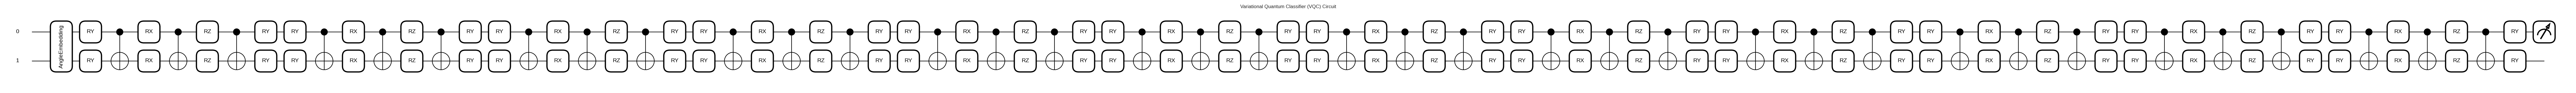

In [ ]:
# Create dummy weights and a data point to draw the circuit
dummy_weights = np.random.uniform(0, 2 * np.pi, size=(num_layers, 12))
dummy_x = np.array([0.5, 0.3])

# Draw the VQC circuit
fig, ax = qml.draw_mpl(vqc_circuit)(dummy_weights, dummy_x)
fig.suptitle("Variational Quantum Classifier (VQC) Circuit")
plt.show()

# You can also get a text-based drawing
#print("VQC Circuit (Text):")
#print(qml.draw(vqc_circuit)(dummy_weights, dummy_x))

**Training the VQC**

We train the VQC by minimizing a cost function (square loss) using a classical optimizer. The optimizer iteratively updates the circuit's weights to improve its accuracy.

In [ ]:
# --- Part 4: Training the VQC ---

def square_loss(labels, predictions):
    """Calculates the mean square loss."""
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    return loss / len(labels)

def cost(weights, X, Y):
    """The cost function to be minimized."""
    # The VQC gives predictions in the range [-1, 1]. We shift the labels to match.
    Y_shifted = Y * 2 - 1
    predictions = [variational_classifier(weights, x) for x in X]
    return square_loss(Y_shifted, predictions)

# Initialize the weights and bias
np.random.seed(0)
circuit_weights = np.random.uniform(0, 2 * np.pi, size=(num_layers, 12))
bias = np.array(0.0, requires_grad=True)
weights = [circuit_weights, bias]

# Set up the optimizer
optimizer = qml.NesterovMomentumOptimizer(0.05)
batch_size = 10
training_steps = 150

print("Training the VQC...")
# Training loop
for i in tqdm(range(training_steps), desc="VQC Training"):
    # Select a batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X_scaled[batch_index]
    Y_batch = Y[batch_index]
    # Update the weights
    weights, cost_val = optimizer.step_and_cost(lambda w: cost(w, X_batch, Y_batch), weights)
    if (i + 1) % 10 == 0:
        print(f"Step {i+1:3d}: Cost = {cost_val:.4f}")

print("VQC training complete.")


Training the VQC...


VQC Training:   0%|          | 0/150 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pennylane/_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Step  10: Cost = 1.7324
Step  20: Cost = 1.2280
Step  30: Cost = 1.5063
Step  40: Cost = 1.9830
Step  50: Cost = 1.8395
Step  60: Cost = 1.3939
Step  70: Cost = 1.8519
Step  80: Cost = 1.2920
Step  90: Cost = 1.4129
Step 100: Cost = 1.7019
Step 110: Cost = 1.5302
Step 120: Cost = 1.5237
Step 130: Cost = 1.5659
Step 140: Cost = 2.0237
Step 150: Cost = 1.7660
VQC training complete.


# **Part 4: Visualize and Compare All Results**
Finally, we'll calculate the accuracy of all three models and plot their decision boundaries to visually compare how they classified the data.

**Calculating Predictions and Accuracy**

Here we generate predictions for a grid of points to visualize the decision boundaries.

In [ ]:
# --- Calculate QSVM Results ---
print("\nPredicting with QSVM...")
grid_resolution_qsvm = 0.2 # Make this larger if its very slow
qsvm_accuracy = qsvm_classifier.score(X_scaled, Y)
x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
xx_qsvm, yy_qsvm = np.meshgrid(np.arange(x_min, x_max, grid_resolution_qsvm), np.arange(y_min, y_max, grid_resolution_qsvm))
grid_points_qsvm = np.c_[xx_qsvm.ravel(), yy_qsvm.ravel()]
qsvm_predictions_grid = qsvm_classifier.predict(grid_points_qsvm)
Z_qsvm = qsvm_predictions_grid.reshape(xx_qsvm.shape)


Predicting with QSVM...


Kernel Rows:   0%|          | 0/100 [00:00<?, ?it/s]

Kernel Rows:   0%|          | 0/575 [00:00<?, ?it/s]

In [ ]:
# --- Calculate Classical SVM Results ---
grid_resolution_svm = 0.2 # Make this larger if its very slow
x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
xx_svm, yy_svm = np.meshgrid(np.arange(x_min, x_max, grid_resolution_svm), np.arange(y_min, y_max, grid_resolution_svm))
grid_points_svm = np.c_[xx_svm.ravel(), yy_svm.ravel()]
svm_accuracy = svm_classifier.score(X_scaled, Y)
svm_predictions_grid = svm_classifier.predict(grid_points_svm)
Z_svm = svm_predictions_grid.reshape(xx_svm.shape)

In [ ]:
# --- Calculate VQC Results ---
print("\nPredicting with VQC...")
grid_resolution_vqc = 0.2 # Make this larger if its very slow
x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
xx_vqc, yy_vqc = np.meshgrid(np.arange(x_min, x_max, grid_resolution_vqc), np.arange(y_min, y_max, grid_resolution_vqc))
grid_points_vqc = np.c_[xx_vqc.ravel(), yy_vqc.ravel()]
vqc_predictions = [np.sign(variational_classifier(weights, x)) for x in tqdm(X_scaled, desc="VQC Predictions")]
vqc_accuracy = np.sum(vqc_predictions == (Y * 2 - 1)) / len(Y)
vqc_predictions_grid = np.array([np.sign(variational_classifier(weights, p)) for p in tqdm(grid_points_vqc, desc="VQC Grid")]).reshape(xx_vqc.shape)


Predicting with VQC...


VQC Predictions:   0%|          | 0/100 [00:00<?, ?it/s]

VQC Grid:   0%|          | 0/575 [00:00<?, ?it/s]

**Plotting the Decision Boundaries**

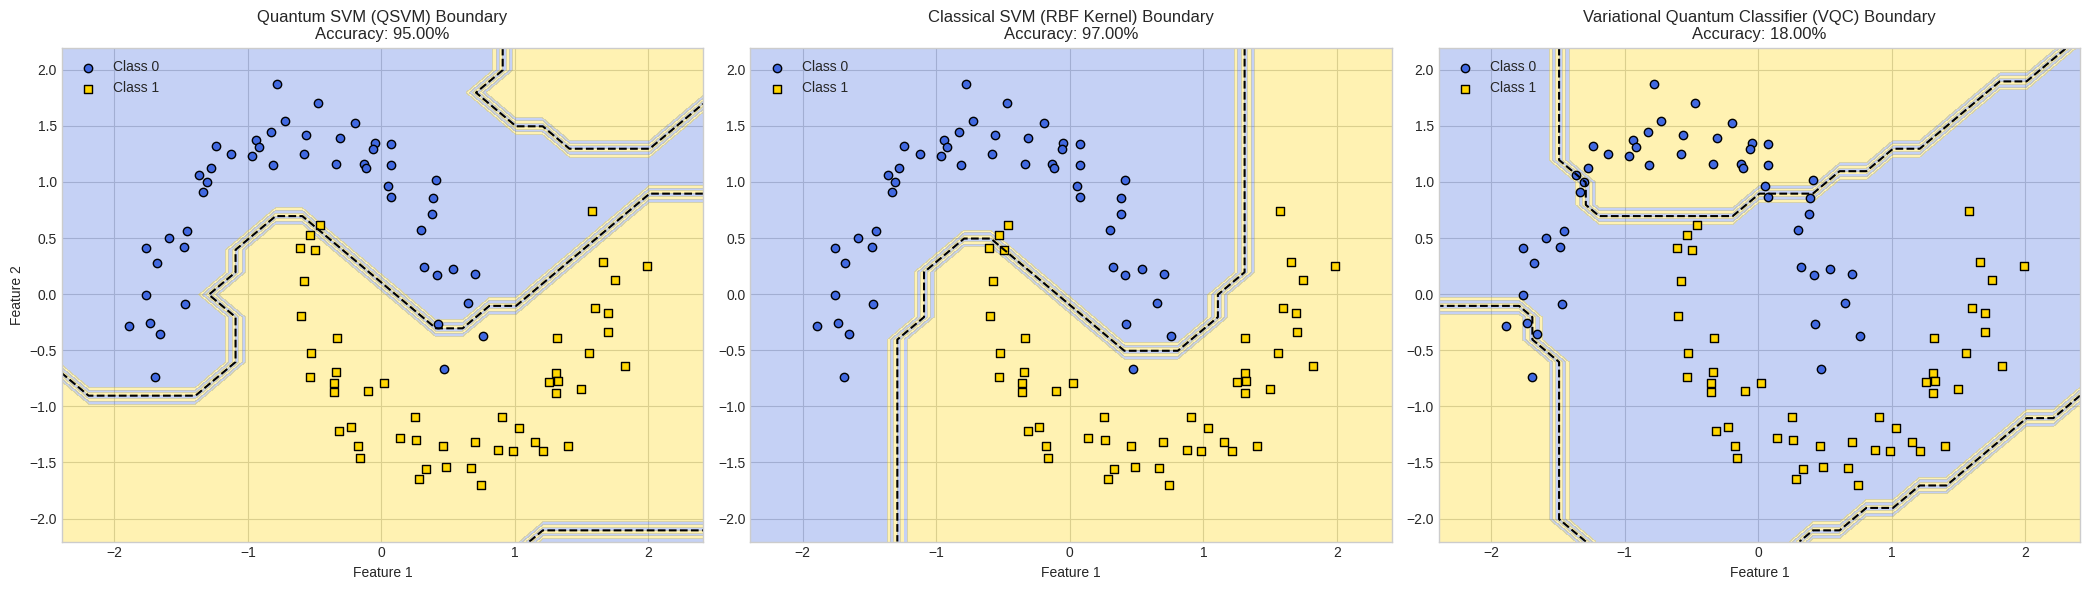


QSVM Accuracy: 0.9500
VQC Accuracy: 0.1800
Classical SVM Accuracy: 0.9700


In [ ]:
# --- Part 6: Visualize and Compare All Results ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

# --- Rescale SVM and QSVM predictions to match VQC's -1 to 1 scale ---
# The original Z_qsvm and Z_svm contain 0s and 1s.
# We map them to -1s and 1s using the formula: y_new = 2*y_old - 1
Z_qsvm_rescaled = 2 * Z_qsvm - 1
Z_svm_rescaled = 2 * Z_svm - 1


# --- Plot QSVM Results ---
# Now using the rescaled data and level=0 for the boundary
ax1.contourf(xx_qsvm, yy_qsvm, Z_qsvm_rescaled, alpha=0.3, colors=["royalblue", "gold"])
ax1.contour(xx_qsvm, yy_qsvm, Z_qsvm_rescaled, levels=[0], colors="black", linestyles="--")
ax1.scatter(X_scaled[Y==0, 0], X_scaled[Y==0, 1], c="royalblue", marker="o", edgecolors="k", label="Class 0")
ax1.scatter(X_scaled[Y==1, 0], X_scaled[Y==1, 1], c="gold", marker="s", edgecolors="k", label="Class 1")
ax1.set_title(f"Quantum SVM (QSVM) Boundary\nAccuracy: {qsvm_accuracy:.2%}")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.legend(loc="upper left")


# --- Plot Classical SVM Results ---
# Now using the rescaled data and level=0 for the boundary
ax2.contourf(xx_svm, yy_svm, Z_svm_rescaled, alpha=0.3, colors=["royalblue", "gold"])
ax2.contour(xx_svm, yy_svm, Z_svm_rescaled, levels=[0], colors="black", linestyles="--")
ax2.scatter(X_scaled[Y==0, 0], X_scaled[Y==0, 1], c="royalblue", marker="o", edgecolors="k", label="Class 0")
ax2.scatter(X_scaled[Y==1, 0], X_scaled[Y==1, 1], c="gold", marker="s", edgecolors="k", label="Class 1")
ax2.set_title(f"Classical SVM (RBF Kernel) Boundary\nAccuracy: {svm_accuracy:.2%}")
ax2.set_xlabel("Feature 1")
ax2.legend(loc="upper left")


# --- Plot VQC Results ---
# The VQC data is already in the -1 to 1 range, so no change is needed here.
# The contour level is set to 0 to match the others.
ax3.contourf(xx_vqc, yy_vqc, vqc_predictions_grid, alpha=0.3, colors=["royalblue", "gold"])
ax3.contour(xx_vqc, yy_vqc, vqc_predictions_grid, levels=[0], colors="black", linestyles="--")
ax3.scatter(X_scaled[Y==0, 0], X_scaled[Y==0, 1], c="royalblue", marker="o", edgecolors="k", label="Class 0")
ax3.scatter(X_scaled[Y==1, 0], X_scaled[Y==1, 1], c="gold", marker="s", edgecolors="k", label="Class 1")
ax3.set_title(f"Variational Quantum Classifier (VQC) Boundary\nAccuracy: {vqc_accuracy:.2%}")
ax3.set_xlabel("Feature 1")
ax3.legend(loc="upper left")


plt.tight_layout()
#plt.savefig("qsvm_vqc_vs_svm_classification.png")
plt.show()

print(f"\nQSVM Accuracy: {qsvm_accuracy:.4f}")
print(f"VQC Accuracy: {vqc_accuracy:.4f}")
print(f"Classical SVM Accuracy: {svm_accuracy:.4f}")